# Inteligencia Artificial y Ciberseguridad
### Analizando muestras de malware con Aprendizaje Máquina y Deep Learning

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from cm import matriz_imprimir
import warnings
warnings.filterwarnings('ignore')

### El conjunto de datos

<p><b>¿Qué es una sandbox?</b></p>

<div style="box-shadow:0 1px 1px rgba(0,0,0,0.15),0 2px 2px rgba(0,0,0,0.15),0 4px 4px rgba(0,0,0,0.15),0 8px 8px rgba(0,0,0,0.15)">Se refiere a un entorno controlado y aislado en el que se ejecutan y analizan programas o archivos potencialmente maliciosos. El objetivo principal de un entorno aislado es observar y estudiar de forma segura el comportamiento del malware sin arriesgarse a dañar un sistema o red real.</div>

<p>El conjunto de muestras está compuesto por llamadas al API32 de Windows de archivos PE (Portable Executables)</p>

<p><b>¿Qué es un archivo PE (Portable Executable)?</b></p>
<div style="box-shadow:0 1px 1px rgba(0,0,0,0.15),0 2px 2px rgba(0,0,0,0.15),0 4px 4px rgba(0,0,0,0.15),0 8px 8px rgba(0,0,0,0.15)">Un archivo PE es un formato para ejecutables, código objeto, DLLs y otros tipos de estructuras utilizados en versiones de 32 y 64 bits para versiones del sistema operativo Windows. Está compuesto por cabeceras y secciones que indican al enlazador dinámico cómo asignar el archivo en memoria.</div>

<p><span style="color:red">Hay detalles que no pueden ocultarse cuando se ejecuta un PE, una de ellas son las llamadas al API del sistema operativo.</span></p>

<p><b>¿Qué es una llamada al API?</b></p>

<div style="box-shadow:0 1px 1px rgba(0,0,0,0.15),0 2px 2px rgba(0,0,0,0.15),0 4px 4px rgba(0,0,0,0.15),0 8px 8px rgba(0,0,0,0.15)">Una llamada a la API (Application Programming Interface call) se refiere a una solicitud realizada por una aplicación o un programa para acceder a una función o servicio específico proporcionado por la API de Windows.</div>

<p>De acuerdo a (<i>Aldo Hernandez-Suarez et al.</i>, 2019, osease yo :)) el análisis de malware con llamadas a la API se refiere al proceso de examinar y analizar dinamicamante la supervisión de la interfaz secuencial, realizada por el PE durante su ejecución.</p>

<p><span style="color:red">¡Podrás camuflajearse pero nunca esconderte!</span></p>

![title](7.jpeg)

<p>Sandboxes como <a href="https://www.hybrid-analysis.com/">Hybrid Analysis</a> nos permiten evaluar en diferentes versiones del sistema operativo Windows y extraer el conjunto de llamadas (secuencias) al API de un determinado PE.</p>

![title](8.png)

<p>Paso 1: ¡Que se haga la magia tenemos un dataset!</p>

In [10]:
dataset = pd.read_csv("dataset.csv")
dataset.head()

y                                                  x
0  1  LoadLibraryW HeapAlloc HeapAlloc HeapFree Heap...
1  1  RegOpenKeyExW LoadLibraryA GetProcAddress GetP...
2  1  HeapAlloc HeapFree HeapAlloc HeapAlloc HeapFre...
3  1  HeapAlloc HeapFree HeapAlloc HeapAlloc HeapFre...
4  1  HeapAlloc HeapFree HeapAlloc HeapAlloc HeapFre...

<p>Para que un algoritmo (estimador) pueda aprender y generalizar qué debe de hacer, necesita una clase objetivo (ejemplo) y una no objetivo (contra-ejemplo):</p>

<ol>
<li>	Clase con etiqueta $1$: el objetivo es detectar malware</li>
<li>	Clase con etiqueta $0$: el objetivo es saber que también existe software benigno (benignware)</li>
</ol>

<p><b>Paso 2</b>: visualizar el tamaño del conjunto de datos y cantidad de muestras por clase</p>

In [11]:
dataset.shape

(388, 2)

<p>El dataset está compuesto por $388$ filas y $2$ columnas. La columna <b>x</b> representa las muestras y la $y$ las etiquetas o clases.</p>

In [59]:
print("Existen",len(dataset[dataset['y']==1]),"muestras de malware")
print("Existen",len(dataset[dataset['y']==0]),"muestras de benignware")

Existen 320 muestras de malware
Existen 68 muestras de benignware


<p><b>Paso 3</b>: observar los tipos de datos.</p>

In [60]:
dataset.dtypes

y     int64
x    object
dtype: object

<p>Se observa que la columna <b>y</b> tiene valores enteros, esto es porque solo representarán las etiquetas numéricas correspondientes a cada muestra. A veces, les denominamos valores discretos (números enteros que siguen una secuencia $0,1,2,\dots$).</p>

<p>Por otro lado, la columna <b>x</b> contiene valores tipo <code>object</code>, esto significa que son cadenas de caracteres en su mayoría.</p>

<p><span style="color:blue;border: 15px solid blue;"><b>Spoiler de tristeza</b></span>
Los algoritmos de Aprendizaje Máquina, no pueden entender cadenas de caracteres :(
</p>

### ¡El modelo de espacio vectorial al rescate!

<p><b>¿Qué es el modelo de espacio vectorial?</b>
<div style="box-shadow:0 1px 1px rgba(0,0,0,0.15),0 2px 2px rgba(0,0,0,0.15),0 4px 4px rgba(0,0,0,0.15),0 8px 8px rgba(0,0,0,0.15)">Se trata de un marco matemático que transforma datos textuales en vectores numéricos, lo que permite a las máquinas procesar y analizar información textual.</div>

<p>Nuestro dataset tiene llamadas al API que pueden se representadas como palabras o términos.</p>

<p><b>Paso 4</b>: evaluar cuál es la transformación más apropiada.</p>

![title](9.png)

<p>Como buena práctica las muestras se identifican con la letra $X$ y las etiquetas con la letra $y$</p>

In [61]:
X = dataset['x']
y = dataset['y']

In [62]:
X.head()

0    LoadLibraryW HeapAlloc HeapAlloc HeapFree Heap...
1    RegOpenKeyExW LoadLibraryA GetProcAddress GetP...
2    HeapAlloc HeapFree HeapAlloc HeapAlloc HeapFre...
3    HeapAlloc HeapFree HeapAlloc HeapAlloc HeapFre...
4    HeapAlloc HeapFree HeapAlloc HeapAlloc HeapFre...
Name: x, dtype: object

<p>Veamos como se ve una muestra transformada por One-hot-encoding.</p>

In [63]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorizar las muestras
vectorizer = CountVectorizer()
X_ohe = vectorizer.fit_transform(X)

In [64]:
print("Existen",len(vectorizer.get_feature_names_out()),"llamadas (palabras únicas)")
print("Cada muestra será transformada a ese tamaño denominado vocabulario")
print("Tamaño de la primer muestra sin transformar (cantidad de palabras)",len(X.values[0].split(" ")))
print("Tamaño de la primer muestra transformada",len(X_ohe.toarray()[0]))
#print("Vocabulario",vectorizer.get_feature_names_out())

Existen 313 llamadas (palabras únicas)
Cada muestra será transformada a ese tamaño denominado vocabulario
Tamaño de la primer muestra sin transformar (cantidad de palabras) 1620
Tamaño de la primer muestra transformada 313


<p>Así se ve de bonito un dataset categórico transformado a números.</p>

In [65]:
df_ohe = pd.DataFrame(X_ohe.toarray(), columns=vectorizer.get_feature_names_out())
df_ohe

_lclose  _llseek  _lread  bind  changeserviceconfiga  closeservicehandle  \
0          0        0       0     0                     0                   0   
1          0        0       0     0                     7                 209   
2          0        0       0     0                     0                   0   
3          0        0       0     0                     0                   0   
4          0        0       0     0                     0                   0   
..       ...      ...     ...   ...                   ...                 ...   
383        0        0       0     0                     0                   0   
384        0        0       0     0                     0                   0   
385        0        0       0     0                     0                   0   
386        0        0       0     0                     0                   0   
387        0        0       0     0                     0                   0   

     closesocket  colorscheme  connect  controlservice  ...  \
0              0            0        0               0  ...   
1              1            0        1               7  ...   
2              0            0        0               0  ...   
3              0            0        0               0  ...   
4              0            0        0               0  ...   
..           ...          ...      ...             ...  ...   
383            0            0        0               0  ...   
384            0            0        0               0  ...   
385            0            0        0               0  ...   
386            0            0        0               0  ...   
387            0            0        0               0  ...   

     wsalookupservicebegina  wsalookupservicebeginw  wsalookupserviceend  \
0                         0                       0                    0   
1                         1                       1                    1   
2                         0                       0                    0   
3                         0                       0                    0   
4                         0                       0                    0   
..                      ...                     ...                  ...   
383                       0                       0                    0   
384                       0                       0                    0   
385                       0                       0                    0   
386                       0                       0                    0   
387                       0                       0                    0   

     wsalookupservicenexta  wsalookupservicenextw  wsarecv  wsarecvfrom  \
0                        0                      0        0            0   
1                        1                      1        0            0   
2                        0                      0        0            0   
3                        0                      0        0            0   
4                        0                      0        0            0   
..                     ...                    ...      ...          ...   
383                      0                      0        0            0   
384                      0                      0        0            0   
385                      0                      0        0            0   
386                      0                      0        0            0   
387                      0                      0        0            0   

     wsasetlasterror  wsasocketw  wsastartup  
0                  0           0           0  
1                  0           1           1  
2                  0           0           0  
3                  0           0           0  
4                  0           0           0  
..               ...         ...         ...  
383                0           0           0  
384                0           0           0  
385                0           0      

<p>Veamos como se ve una muestra transformada por One-hot-encoding.</p>

In [66]:
from sklearn.feature_extraction.text  import TfidfVectorizer

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

In [67]:
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
df_tfidf

_lclose  _llseek  _lread  bind  changeserviceconfiga  closeservicehandle  \
0        0.0      0.0     0.0   0.0              0.000000            0.000000   
1        0.0      0.0     0.0   0.0              0.021593            0.553212   
2        0.0      0.0     0.0   0.0              0.000000            0.000000   
3        0.0      0.0     0.0   0.0              0.000000            0.000000   
4        0.0      0.0     0.0   0.0              0.000000            0.000000   
..       ...      ...     ...   ...                   ...                 ...   
383      0.0      0.0     0.0   0.0              0.000000            0.000000   
384      0.0      0.0     0.0   0.0              0.000000            0.000000   
385      0.0      0.0     0.0   0.0              0.000000            0.000000   
386      0.0      0.0     0.0   0.0              0.000000            0.000000   
387      0.0      0.0     0.0   0.0              0.000000            0.000000   

     closesocket  colorscheme   connect  controlservice  ...  \
0       0.000000          0.0  0.000000        0.000000  ...   
1       0.002598          0.0  0.002727        0.021593  ...   
2       0.000000          0.0  0.000000        0.000000  ...   
3       0.000000          0.0  0.000000        0.000000  ...   
4       0.000000          0.0  0.000000        0.000000  ...   
..           ...          ...       ...             ...  ...   
383     0.000000          0.0  0.000000        0.000000  ...   
384     0.000000          0.0  0.000000        0.000000  ...   
385     0.000000          0.0  0.000000        0.000000  ...   
386     0.000000          0.0  0.000000        0.000000  ...   
387     0.000000          0.0  0.000000        0.000000  ...   

     wsalookupservicebegina  wsalookupservicebeginw  wsalookupserviceend  \
0                   0.00000                 0.00000              0.00000   
1                   0.00304                 0.00304              0.00304   
2                   0.00000                 0.00000              0.00000   
3                   0.00000                 0.00000              0.00000   
4                   0.00000                 0.00000              0.00000   
..                      ...                     ...                  ...   
383                 0.00000                 0.00000              0.00000   
384                 0.00000                 0.00000              0.00000   
385                 0.00000                 0.00000              0.00000   
386                 0.00000                 0.00000              0.00000   
387                 0.00000                 0.00000              0.00000   

     wsalookupservicenexta  wsalookupservicenextw  wsarecv  wsarecvfrom  \
0                  0.00000                0.00000      0.0          0.0   
1                  0.00304                0.00304      0.0          0.0   
2                  0.00000                0.00000      0.0          0.0   
3                  0.00000                0.00000      0.0          0.0   
4                  0.00000                0.00000      0.0          0.0   
..                     ...                    ...      ...          ...   
383                0.00000                0.00000      0.0          0.0   
384                0.00000                0.00000      0.0          0.0   
385                0.00000                0.00000      0.0          0.0   
386                0.00000                0.00000      0.0          0.0   
387                0.00000                0.00000      0.0          0.0   

     wsasetlasterror  wsasocketw  wsastartup  
0                0.0    0.000000    0.000000  
1                0.0    0.002673    0.002261  
2                0.0    0.000000    0.000000  
3                0.0    0.000000    0.000000  
4                0.0    0.000000    0.000000  
..               ...         ...         ...  
383              0.0    0.000000    0.000000  
384              0.0    0.000000    0.000000  
385              0.0    0.

<p><span style="color:red">Desgraciadamente la transformación por Word embeddings consume muchos recursos y tardaremos mucho en general un modelo vectorial ☹</span></p>

<p><b>Paso 5</b>: seleccionar un estimador.</p>
<p>La elección del estimador (algoritmo) depende de varios factores, como la naturaleza de los datos, el tipo de tarea (clasificación, regresión, agrupación), el tamaño del conjunto de datos y los objetivos.</p>
<p>Afortunadamente sklearn nos brinda una idea con un mapa mental de qué estimador (algoritmo) seleccionar. En este caso seleccionaremos tres muy populares:</p>

<ol>
   <li><b>Árboles de Decisión</b>: es un estimador en forma de árbol que toma decisiones dividiendo recursivamente el conjunto de datos en subconjuntos en función de los valores de la característica de entrada </li>
   <li> <b>Máquina de Soporte Vectorial</b>: es un poderoso estimador conocido por su eficacia en espacios de alta dimensión (muchas columnas o características) y su capacidad para encontrar un hiperplano que separe mejor los datos en clases distintas maximizando el margen entre las clases.</li>
    <li><b>Regresión Logística</b>: es un algoritmo muy eficaz para modelar la relación entre una variable dependiente binaria (malware) y una o más variables independientes (columnas o características) estimando la probabilidad del resultado binario.</li>
</ol>

#### Pipeline de Sklearn de algoritmos de Aprendizaje Máquina


<p>Para poder evaluar el desempeño del algoritmo, es necesario dividir las muestras en dos conjuntos importantes:</p> 

<ol>
<li>	$X_t$ conjunto de entrenamiento: será utilizado para que el estimador aprenda de las muestras y sus características</li>
<li>		$X_p$ conjunto de prueba: será utilizado para medir que tan bien clasifica el modelo resultante con muestras no conocidas</li>	
</ol>

<p><i>Todo debe de seguir un orden</i></p>
<p><img src="6.png" alt="sklearn-pipeline" class="bg primary"width="400px"></p>

In [68]:
#60% de muestras aleatorias sin reemplazo para entrenar y 40% de muestras aleatorias sin reemplazo para probar
X_train,X_test,y_train,y_test = train_test_split(X_tfidf,y,test_size=.4)

In [97]:
### Primer entrenamiento con Árboles de Decisión y muestras transformadas con TF-IDF
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [98]:
#predicciones
y_pred_dt = dt.predict(X_test)

In [99]:
### Segundo entrenamiento con Máquina de Soporte Vectorial y muestras transformadas con TF-IDF
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train,y_train)

SVC()

In [100]:
#predicciones
y_pred_svm = svm.predict(X_test)

In [101]:
### Tercer entrenamiento con Regresión Logística y muestras transformadas con TF-IDF
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [102]:
#predicciones
y_pred_rl = lr.predict(X_test)

#### Evaluando el desempeño
##### Árboles de Decisión

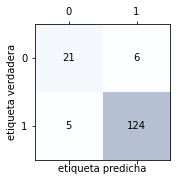

              precision    recall  f1-score   support

           0       0.78      0.81      0.79        26
           1       0.96      0.95      0.96       130

    accuracy                           0.93       156
   macro avg       0.87      0.88      0.87       156
weighted avg       0.93      0.93      0.93       156



In [107]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_dt)
matriz_imprimir(confmat)
print(classification_report(y_pred_dt,y_test))

#### Evaluando el desempeño
##### Máquina de Soporte Vectorial

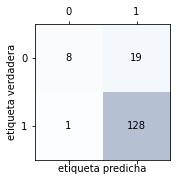

              precision    recall  f1-score   support

           0       0.30      0.89      0.44         9
           1       0.99      0.87      0.93       147

    accuracy                           0.87       156
   macro avg       0.64      0.88      0.69       156
weighted avg       0.95      0.87      0.90       156



In [108]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_svm)
matriz_imprimir(confmat)
print(classification_report(y_pred_svm,y_test))

#### Evaluando el desempeño
##### Regresión Logística

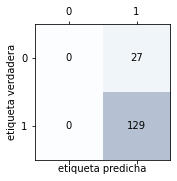

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.83      0.91       156

    accuracy                           0.83       156
   macro avg       0.50      0.41      0.45       156
weighted avg       1.00      0.83      0.91       156



In [110]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_rl)
matriz_imprimir(confmat)
print(classification_report(y_pred_rl,y_test))

## Deep Learning

<p>Deep Learning es un conjunto de métodos que tienen como objetivo modelar datos con arquitecturas complejas, que combinan diferentes transformaciones no-lineales.</p>

![title](1.png)

![title](2.png)


<p>Los bloques elementales de Deep learning son las redes neuronales, combinadas con las redes neuronales profundas.</p>

<p>Existen diferentes arquitecturas de las redes neuronales profundas.</p>

<ol>
<li>	Los perceptrones multi-capa  </li>
<li>		Las redes neuronales convolucionales (adaptadas para imágenes) </li>
<li>		Las redes neuronales recurrentes (para resolver problemas secuenciales) </li>
</ol>

<p>Se basan en una cascada profunda de capas. Necesitan algortimos de optimización estocásticos, inicialización y estructuras inteligentes.</p>

<p><span style="color:blue;border: 15px solid blue;"><b>Spoiler de matemáticas aburridas pero necesarias</b></span></p>

<p>Una red neuronal es una aplicación, no lineal con respecto a sus parámetros $\theta$ que asocian una entrada $x$ con una salida $y = f(x,\theta)$. Las redes neuronales pueden ser utilizadas para problemas de regresión o clasificación.  De manera usual, los parámetros $\theta$, son estimados a partir de una muestra de aprendizaje.</p>


<p>Una neurona artifical es una función $f_j$ de una entrada $x = (x_1,..,x_d)$ pesada por un vector de conexiones de pesos $w_j = (w_{j,1},..,w_{j,d})$, que se completan por el bias de una neurona $b_j$ y se asocian con una función de activación.</p>

\begin{equation}
y_j = \phi(\langle w_j, x \rangle + b_j))
\end{equation}

<p>En la siguiente Figura se muestra el esquema de una red neuronal artificial donde $\sum = \langle w_j, x \rangle + b_j$</p>

![title](3.png)

En la siguiente Figura se muestra una gráfica con algunas funciones de activación comúnmente utilizadas.

![title](4.png)

<p>A continuación se muestra una serie de Figuras de las redes neuronales profundas que parten de la idea del perceptrón multicapa.</p>

![title](5.png)


## Bibliotecas de Deep Learning para Python

<p><b>Tensorflow</b>: biblioteca para el cálculo numérico de alto rendimiento, puede entrenar y ejecutar redes neuronales profundas que pueden ser usadas para desarrollar varias aplicaciones de IA.</p>

<p><b>Keras</b>: Es una API de redes neuronales de alto nivel capaz de funcionar sobre TensorFlow.</p>


<div style="box-shadow:0 1px 1px rgba(0,0,0,0.15),0 2px 2px rgba(0,0,0,0.15),0 4px 4px rgba(0,0,0,0.15),0 8px 8px rgba(0,0,0,0.15)">
Un <b>tensor</b> es cierta clase de entidad algebraica que generaliza los conceptos de escalar, vector y matriz de una forma que sea independiente de cualquier sistema de coordenadas elegido. 
</div>

In [4]:
#Sys: manipular el ambiente del lenguaje de programación instalación de paquetes
#import sys
#!{sys.executable} Ejecuta el comando de instalación de paquetes pip
#!{sys.executable} -m pip install tensorflow
#!{sys.executable} -m pip install keras
#%pip install tensorflow
#%pip install keras

In [133]:
#dividir el conjunto en entrenamiento y prueba
from sklearn.model_selection import train_test_split
#Estandariza con respecto a la media
from sklearn.preprocessing import StandardScaler
#Genera un objeto para seguir una serie de secuencias
from sklearn.pipeline import Pipeline
#Transformar categorías a valores discretos 
#LabelEncoder [a,b,c]->[0,1,2]
#OneHotEncoder [a,b,c],[c,d,d]->dict->a,b,c,d->[1,1,1,0],[0,0,1,1]
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras 
#Tipo de red de red neuronal
from keras.models import Sequential 
#El tipo de capas
from keras.layers import Dense, Activation
#ignorar los mensajes de depuración
import warnings
warnings.filterwarnings('ignore')
import os
#ignorar los mensajes de depuración de tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

In [177]:
caracteristicas = X_train[0].shape[1]
#Carcasa
classifier = Sequential()

In [192]:
#capa de entrada
#unidades es el número de nodos interconectados por capa
#kernel_initializer es la forma en inicializar los pesos
#activation es la función de activación
#input_dim es la dimensión de la muestra
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', 
                     activation = 'relu', input_dim = caracteristicas))

In [193]:
#capa oculta
classifier.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))

In [194]:
#capa salida
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'tanh'))
#classifier.add(Activation('softmax'))

In [195]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [196]:
classifier.fit(X_train.toarray(), y_train, batch_size = 5, epochs = 100)

Epoch 1/100
47/47 [==============================] - 1s 2ms/step - loss: 4.1098 - accuracy: 0.1767
Epoch 2/100
47/47 [==============================] - 0s 2ms/step - loss: 2.8029 - accuracy: 0.1767
Epoch 3/100
47/47 [==============================] - 0s 2ms/step - loss: 1.5172 - accuracy: 0.1767
Epoch 4/100
47/47 [==============================] - 0s 1ms/step - loss: 0.7226 - accuracy: 0.4009
Epoch 5/100
47/47 [==============================] - 0s 1ms/step - loss: 0.2284 - accuracy: 1.0000
Epoch 6/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0694 - accuracy: 1.0000
Epoch 7/100
47/47 [==============================] - 0s 1ms/step - loss: 0.0306 - accuracy: 1.0000
Epoch 8/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 1.0000
Epoch 9/100
47/47 [==============================] - 0s 1ms/step - loss: 0.0108 - accuracy: 1.0000
Epoch 10/100
47/47 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 1.0000
Epoch 11/

Epoch 81/100
47/47 [==============================] - 0s 1ms/step - loss: 7.7138e-05 - accuracy: 1.0000
Epoch 82/100
47/47 [==============================] - 0s 2ms/step - loss: 7.4232e-05 - accuracy: 1.0000
Epoch 83/100
47/47 [==============================] - 0s 2ms/step - loss: 7.1453e-05 - accuracy: 1.0000
Epoch 84/100
47/47 [==============================] - 0s 2ms/step - loss: 6.8809e-05 - accuracy: 1.0000
Epoch 85/100
47/47 [==============================] - 0s 2ms/step - loss: 6.6297e-05 - accuracy: 1.0000
Epoch 86/100
47/47 [==============================] - 0s 2ms/step - loss: 6.3904e-05 - accuracy: 1.0000
Epoch 87/100
47/47 [==============================] - 0s 2ms/step - loss: 6.1575e-05 - accuracy: 1.0000
Epoch 88/100
47/47 [==============================] - 0s 2ms/step - loss: 5.9334e-05 - accuracy: 1.0000
Epoch 89/100
47/47 [==============================] - 0s 2ms/step - loss: 5.7220e-05 - accuracy: 1.0000
Epoch 90/100
47/47 [==============================] - 0s 1ms/ste

In [200]:
y_pred_nn = classifier.predict(X_test.toarray())

5/5 [==============================] - 0s 1ms/step


In [201]:
#y_pred

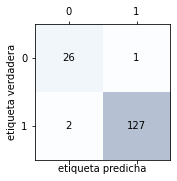

              precision    recall  f1-score   support

        -0.0       0.96      0.93      0.95        28
         1.0       0.98      0.99      0.99       128

    accuracy                           0.98       156
   macro avg       0.97      0.96      0.97       156
weighted avg       0.98      0.98      0.98       156



In [202]:
#Función piso (normalizar)
y_pred_nn = np.ceil(y_pred_nn)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_nn)
matriz_imprimir(confmat)
print(classification_report(y_pred_nn,y_test))